# (Simulation) Earthquake
> Example 1

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [논문연구]

#### 5.1.1 SPECTRAL NETWORK

$$g_{\theta} \star x = U g_{\theta}(\Lambda) U^{\top}x$$

$x$는 실수($n \times 1$ or $1 \times n$), $g_{\theta}$는 $\theta$의 대각행렬, $\theta$는 실수($n \times 1$ or $1 \times n$)

$U$가 정규화된 그래프 라플라시안의 고유벡터 행렬일떄($L = I_N - D^{-\frac{1}{2}}AD^{-\frac{1}{2}} = U\Lambda U^{\top}$), 고유값 $\Lambda$의 대각 행렬을 가진다.

Bruna가 재안한 operation에서 Henaff 는 평활 계수를 가진 파라미터로 차원적이며 집약적인 spectral filters 를 만듦

---

$W$가 $n \times n$  대칭 행렬

$L = I_N - D^{-\frac{1}{2}}WD^{-\frac{1}{2}}$

$D_{ij} = \sum_{ij}W_{ij}$

$U = (u_1, \dots, u_N)$

$X = \mathbb{R}^N$

$x *_Gg = U^{\top} (U_x \odot U)g)$

$\odot$: a point-wise product

$w_g = (w_1, \dots, w_N)$

$x *_Gg := U^{\top} (diag(w_g)U_x)$

---

#### 5.1.2 CHEBNET

$$g_{\theta} \star x \approx  \sum^{K}_{k=0}\theta_k T_k (\tilde{L})x$$

 The Chebyshev polynomials 체비셰프 다항식

$\tilde{L} = \cfrac{2}{\lambda_{max}} L - I_N$

$\lambda_{max}$는 라플라시안 고유값들 중 가장 큰 값

$T_k (x) = 2xT_{k-1}(x) - T_{k-2} (x)$

$T_0 (x) = 1$, $T_1(x) = x$

## imports

In [1]:
import rpy2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
from haversine import haversine
from IPython.display import HTML

In [3]:
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

## EbayesThresh

In [4]:
%load_ext rpy2.ipython

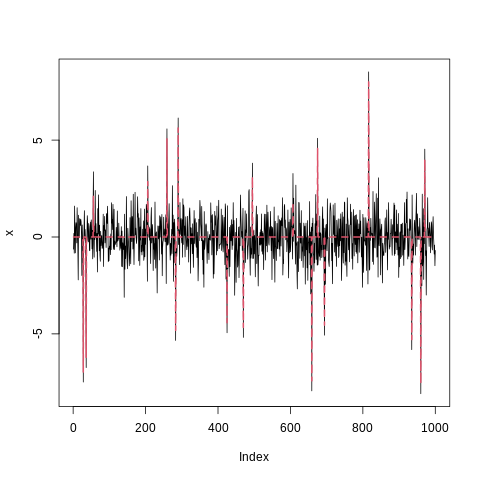

In [5]:
%%R
library(EbayesThresh)
set.seed(1)
x <- rnorm(1000) + sample(c( runif(25,-7,7), rep(0,975)))
plot(x,type='l')
mu <- EbayesThresh::ebayesthresh(x)
lines(mu,col=2,lty=2,lwd=2)

### R + python

`-` R환경에 있던 x를 가지고 오기

In [6]:
%R -o x 

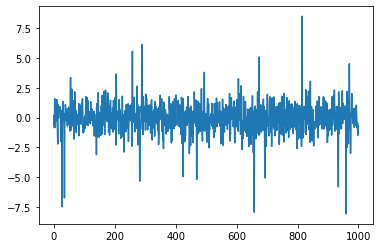

In [7]:
plt.plot(x)

`-` R환경에 있는 ebayesthresh 함수를 가지고 오기

In [8]:
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

In [9]:
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [10]:
xhat = np.array(ebayesthresh(FloatVector(x)))

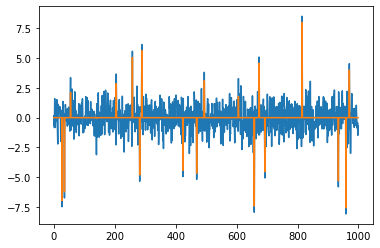

In [11]:
plt.plot(x)
plt.plot(xhat)

## 시도

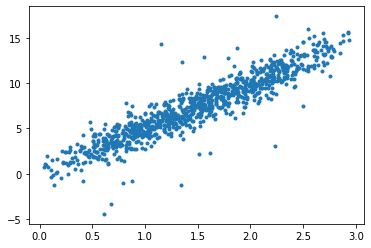

In [12]:
_x = np.linspace(0,1,1000) + 2*np.random.rand(1000) 
_y = 5*_x  +x
plt.plot(_x,_y,'.')

In [13]:
df = pd.DataFrame(_x,_y).reset_index().rename(columns={'index':'x',0:'y'})

In [14]:
_matrix = np.zeros((1000,1000))

In [15]:
for i in range(1,len(_matrix)-1):
    for j in range(i+1,i+2): 
        _matrix[i,j]=1

In [16]:
w = _matrix + _matrix.T
w[0,1]=1
w[1,0]=1

In [17]:
class SIMUL:
    def __init__(self,df):
        self.df = df 
        self.y = df.y.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit2(self): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2)))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)
        plt.plot(self.y,'.')
        plt.plot(self.yhat,'x')

In [18]:
_simul = SIMUL(df)

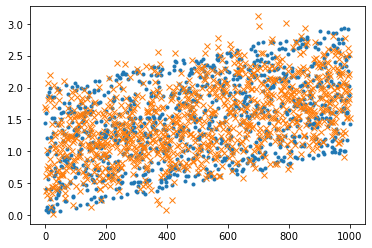

In [19]:
_simul.fit2()

In [20]:
_simul.df

,x,y,yHat,Residual
0,6.580345,1.441360,1.697600,-0.256240
1,8.179800,1.599231,1.660697,-0.061465
2,1.230591,0.413244,0.608863,-0.195619
3,1.973875,0.075719,0.378769,-0.303050
4,6.356294,1.205357,1.022311,0.183046
...,...,...,...,...
995,9.835968,2.029852,2.219356,-0.189504
996,11.591061,2.494346,2.519093,-0.024747
997,8.971688,1.878195,1.820367,0.057828
998,7.938565,1.884263,1.943713,-0.059450


In [21]:
_simul.df.sort_values('Residual',ascending=False).iloc[:5,:]

,x,y,yHat,Residual
963,14.991272,2.556064,1.643241,0.912823
716,10.176307,2.098020,1.193981,0.904039
978,15.482422,2.691073,1.798539,0.892534
442,11.345787,2.272809,1.415499,0.857311
916,13.700808,2.780125,1.924144,0.855981


In [22]:
_simul.df.sort_values('Residual',ascending=True).iloc[:5,:]

,x,y,yHat,Residual
912,6.581630,1.610102,2.505066,-0.894964
191,3.150800,0.549758,1.317016,-0.767259
167,-0.424245,0.200050,0.965440,-0.765390
380,3.529422,0.553367,1.307485,-0.754117
149,1.478964,0.623914,1.354423,-0.730509


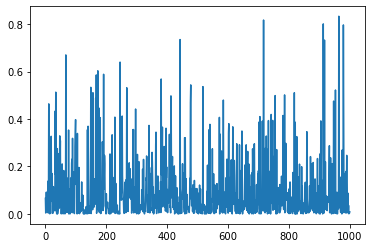

In [23]:
plt.plot((_simul.df.Residual)**2)

---

In [24]:
N = 1000

$MSE$

In [25]:
1/N*np.sum((_simul.df.Residual)**2)

0.09613834028220677

$R^2$

In [26]:
1-(np.sum((_simul.df.Residual)**2)/(np.sum((_simul.df.y-np.mean(_simul.df.y))**2)))

0.7701559416562852